### <center>😭 Escolhendo o modelo de <strong>previsão</strong> 😨</center>

Importações

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB

from sklearn import tree

Carregando os dados

In [73]:
caminho = 'viajou-tratado copy.xlsx'
df = pd.read_excel(caminho)

Separando dados em características e alvo

In [74]:
X = df.drop('probabilidade_recomendar', axis=1)
y = df['probabilidade_recomendar']

Preprocessamento dos dados

In [75]:
label_encoder = LabelEncoder()

for i in X:
    if X[i].dtype == 'object':
        X[i] = label_encoder.fit_transform(X[i])

# Substituindo os valores 1 e 2 por 0, e 3 e 4 por 1
y = y.replace({1: 0, 2: 0, 3: 1, 4: 1})

y

0      1
1      1
2      1
3      1
4      1
      ..
108    1
109    0
110    0
111    1
112    0
Name: probabilidade_recomendar, Length: 113, dtype: int64

Divisão dos dados em treino e teste

In [76]:
size = 0.3
rst = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=rst)

#### Gaussian Naive Bayes

In [77]:
gaus = GaussianNB()

gaus.fit(X_train, y_train)
y_pred_gaus = gaus.predict(X_test)

# Métricas
accuracy_gaus = accuracy_score(y_test, y_pred_gaus)
report_gaus = classification_report(y_test, y_pred_gaus)
cm_gaus = confusion_matrix(y_test, y_pred_gaus)

#### Arvore de Decisão

Com base no GridSearchCV os 'melhores' paramêtros foram decidido para a arvore de decisão

In [78]:
# from sklearn.model_selection import GridSearchCV

# param = {
#     'criterion': ['gini', 'entropy'],
#     'splitter': ['best', 'random'],
#     'max_depth': [2, 4, 6, 8, 10, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 5, 10],
#     'max_features': [None, 'sqrt', 'log2']
# }

# grid = GridSearchCV(estimator=tree.DecisionTreeClassifier(), param_grid=param, scoring='accuracy')
# grid.fit(X_train, y_train)

# print(grid.best_params_)
# print(grid.best_score_)

#### Gini

In [79]:
gini = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, max_features='log2', min_samples_leaf=5, min_samples_split=2, splitter='random')
gini.fit(X_train, y_train)
y_pred_gini = gini.predict(X_test)

# Métricas
accuracy_gini = accuracy_score(y_test, y_pred_gini)
report_gini = classification_report(y_test, y_pred_gini)
cm_gini = confusion_matrix(y_test, y_pred_gini)

print(report_gini)

              precision    recall  f1-score   support

           0       0.33      0.12      0.18         8
           1       0.77      0.92      0.84        26

    accuracy                           0.74        34
   macro avg       0.55      0.52      0.51        34
weighted avg       0.67      0.74      0.69        34



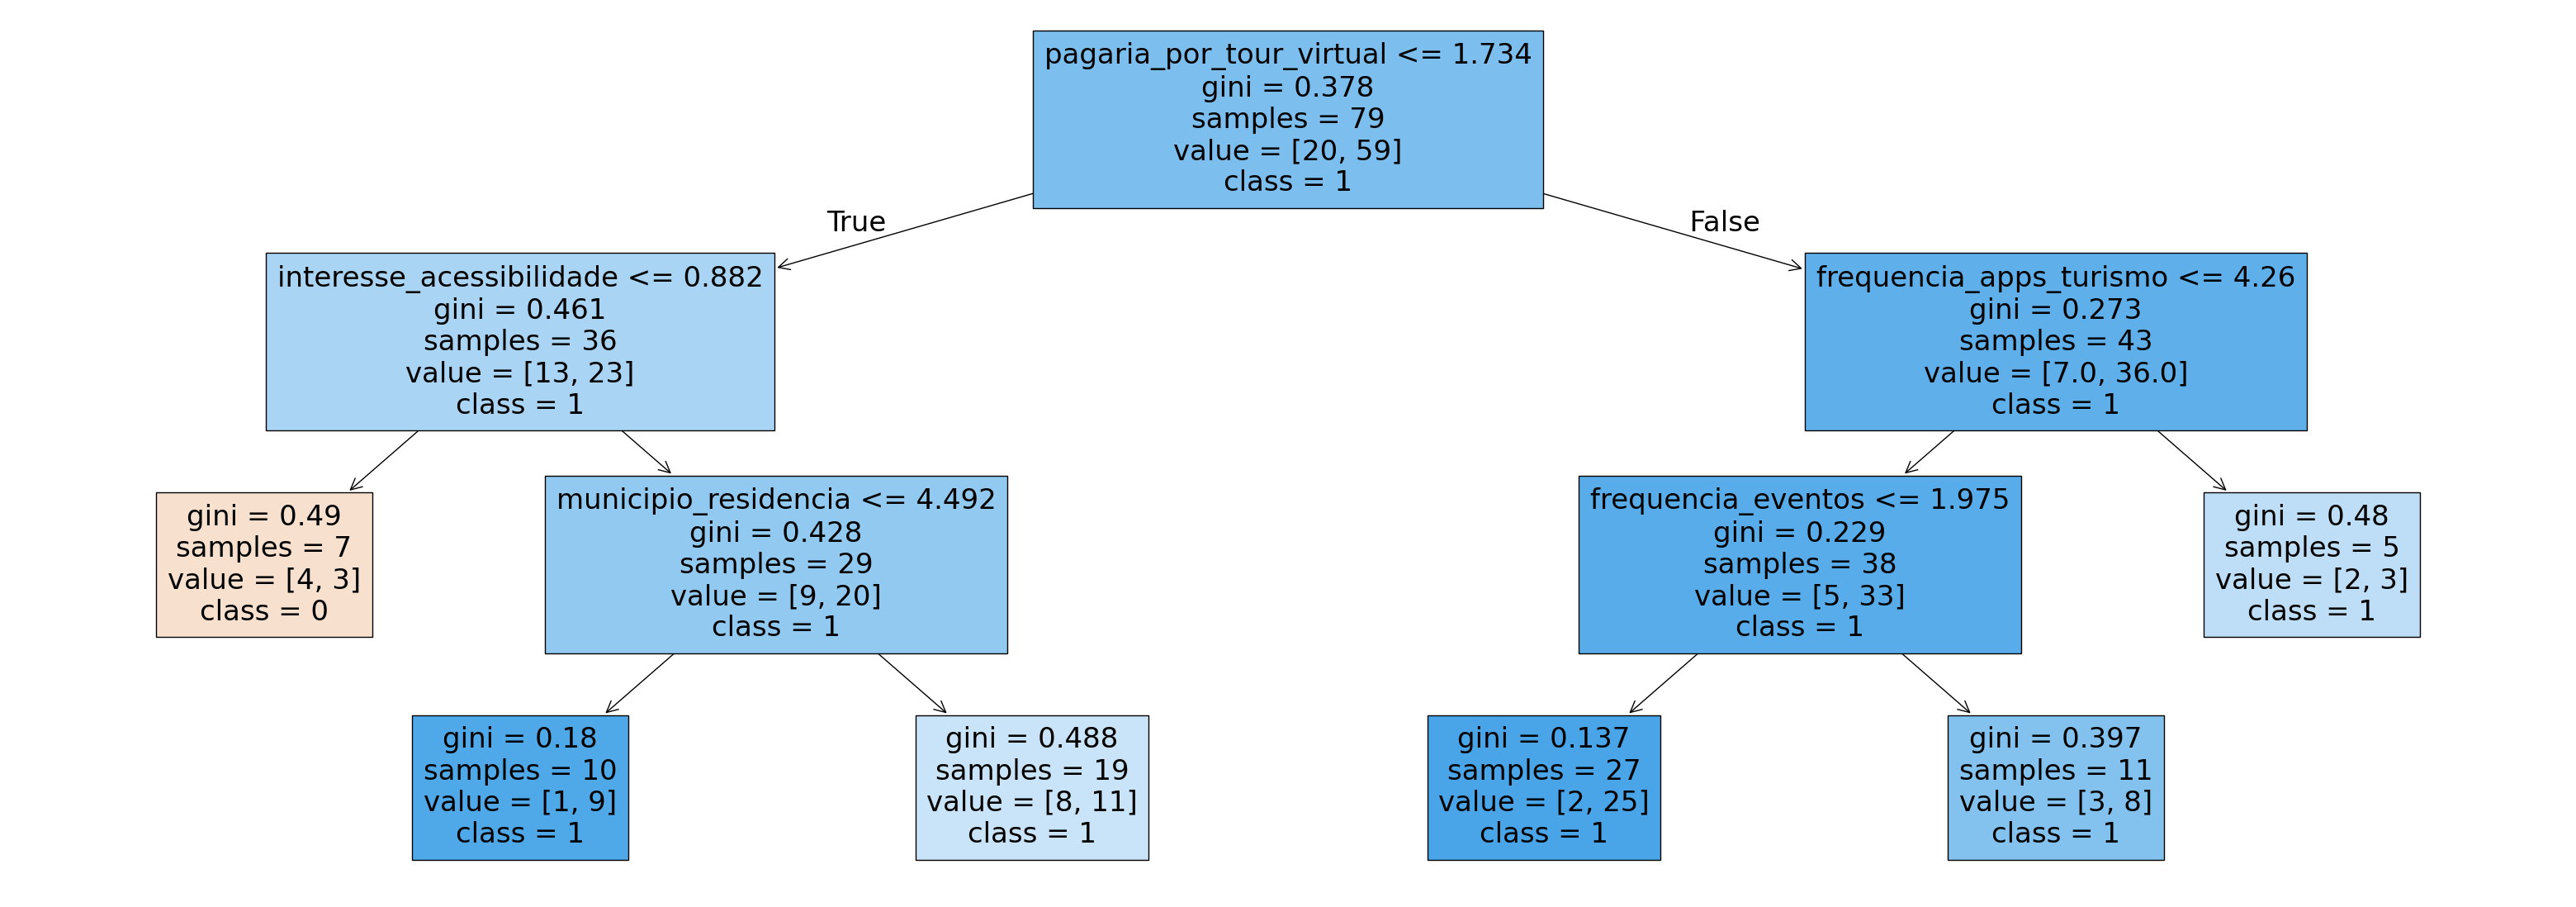

In [80]:
# Configurando a visualização da árvore de decisão
plt.figure(figsize=(40, 14))
tree.plot_tree(gini, feature_names=X.columns.tolist(),
               class_names=[str(cls) for cls in gini.classes_], filled=True)  # Convertendo classes para strings

plt.show()  # Mostra a figura


#### KNN

Descobrindo o Melhor K

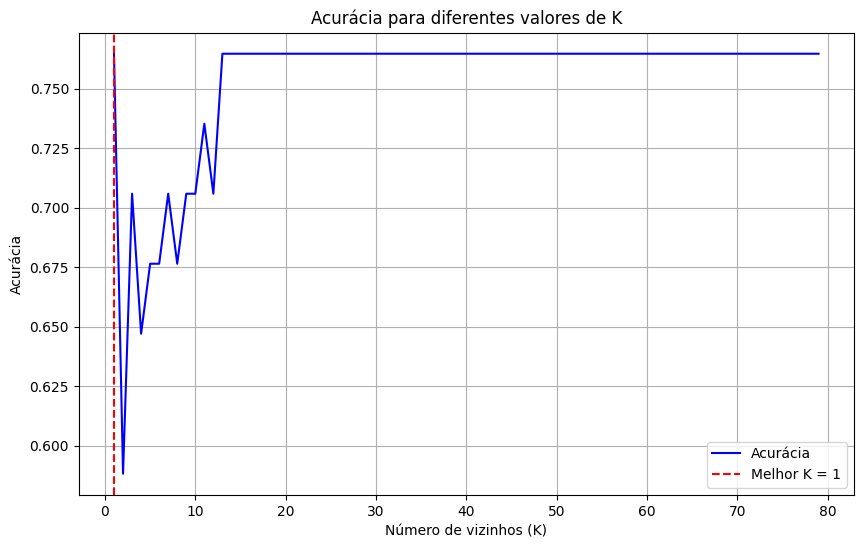

In [81]:
from sklearn.neighbors import KNeighborsClassifier

acuracias = {}

for i in range(1, 80):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    acuracias[i] = accuracy_knn
    
melhor_k = max(acuracias, key=acuracias.get)

plt.figure(figsize=(10, 6))
plt.plot(list(acuracias.keys()), list(acuracias.values()), color='b', label='Acurácia')
plt.axvline(x=melhor_k, color='r', linestyle='--', label=f'Melhor K = {melhor_k}')
plt.title('Acurácia para diferentes valores de K')
plt.xlabel('Número de vizinhos (K)')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Métricas
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)

### <center>Exibindo as métricas e as matrizes de confusão</center>

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         8
           1       0.85      0.85      0.85        26

    accuracy                           0.76        34
   macro avg       0.67      0.67      0.67        34
weighted avg       0.76      0.76      0.76        34



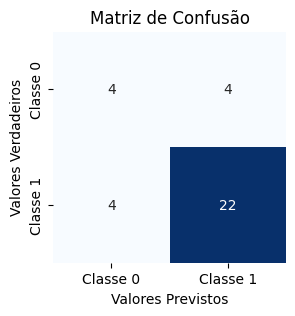

              precision    recall  f1-score   support

           0       0.33      0.12      0.18         8
           1       0.77      0.92      0.84        26

    accuracy                           0.74        34
   macro avg       0.55      0.52      0.51        34
weighted avg       0.67      0.74      0.69        34



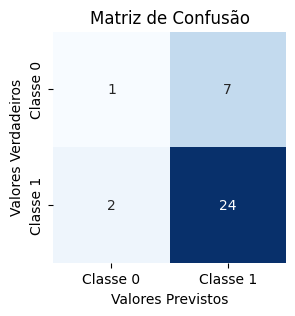

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         8
           1       0.85      0.85      0.85        26

    accuracy                           0.76        34
   macro avg       0.67      0.67      0.67        34
weighted avg       0.76      0.76      0.76        34



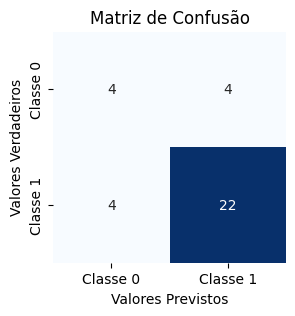

In [83]:
print(report_gaus)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_gaus, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])

# Adicionando títulos e labels
plt.title('Matriz de Confusão')
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Verdadeiros')
plt.show()

print(report_gini)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_gini, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])

# Adicionando títulos e labels
plt.title('Matriz de Confusão')
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Verdadeiros')
plt.show()

print(report_knn)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])

# Adicionando títulos e labels
plt.title('Matriz de Confusão')
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Verdadeiros')
plt.show()

#### Escolha do modelo

A árvore de decisão com os parâmetros ajustados pelo GridSearchCV é escolhida com base em uma melhor acurácia e balanceamento entre as classes.